In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime

# Data Ingestion 
Data is ingested and the index for the dataset is set to `Date` column

In [2]:
daily_cases = pd.read_csv('../../cleaned_datasets/india/daily_cases_india.csv')
daily_cases['Date'] = pd.to_datetime(daily_cases['Date'], format = '%Y-%m-%d')
daily_cases

,Unnamed: 0,Date,Confirmed,Deaths,Recovered,Active
0,0,2020-01-30,1.0,0.0,0.0,0.0
1,1,2020-01-31,0.0,0.0,0.0,0.0
2,2,2020-02-01,0.0,0.0,0.0,0.0
3,3,2020-02-02,1.0,0.0,0.0,0.0
4,4,2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
617,617,2021-10-08,19740.0,248.0,0.0,0.0
618,618,2021-10-09,18166.0,214.0,0.0,0.0
619,619,2021-10-10,18132.0,193.0,0.0,0.0
620,620,2021-10-11,14313.0,181.0,0.0,0.0


In [3]:
indexed = daily_cases.set_index('Date')
indexed

,Unnamed: 0,Confirmed,Deaths,Recovered,Active
Date,,,,,
2020-01-30,0,1.0,0.0,0.0,0.0
2020-01-31,1,0.0,0.0,0.0,0.0
2020-02-01,2,0.0,0.0,0.0,0.0
2020-02-02,3,1.0,0.0,0.0,0.0
2020-02-03,4,1.0,0.0,0.0,0.0
...,...,...,...,...,...
2021-10-08,617,19740.0,248.0,0.0,0.0
2021-10-09,618,18166.0,214.0,0.0,0.0
2021-10-10,619,18132.0,193.0,0.0,0.0


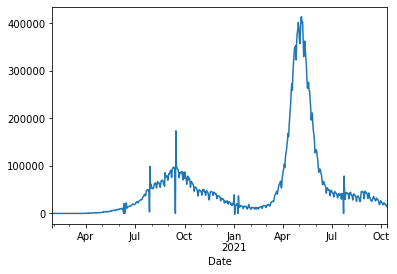

In [4]:
indexed['Confirmed'].plot()

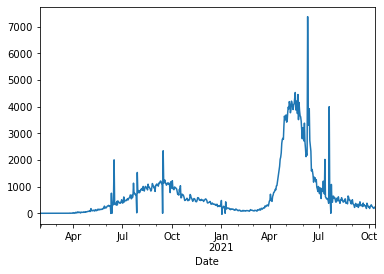

In [5]:
indexed['Deaths'].plot()

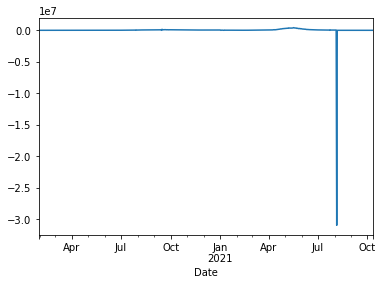

In [6]:
indexed['Recovered'].plot()

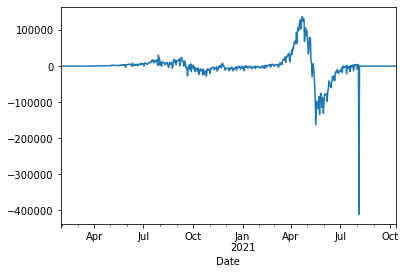

In [7]:
indexed['Active'].plot()

**Train Test Split**     
Keep upto `08-08-2021` or 0.895 of overall timeseries as train for timeseries and beyond that for forecasting. This also eliminates the outlier caused due to missing data in `Recovered`

In [8]:
# train = indexed[:"2021-08-08"]
# val = indexed["2021-08-09":]

splitlen = int(0.895*len(daily_cases))

# train = daily_cases[:splitlen-3]
# val = daily_cases[splitlen+1-3:]

train = daily_cases[:splitlen]
val = daily_cases[splitlen:]

train = train.set_index('Date')
val = val.set_index('Date')

# train = indexed[:"2021-07-04"]
# val = indexed["2021-07-05":]

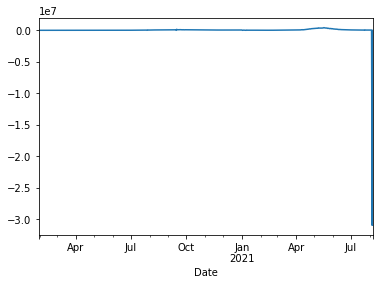

In [9]:
train['Recovered'].plot()

In [10]:
confirmed_ts = train['Confirmed'].dropna()

In [11]:
#Unvariate Time Series for Confirmed Cases 
def roll_stats(ts, window):
  ''' Function to find rolling mean and rolling std dev and plot them'''
  rollmean = ts.rolling(window = window).mean()
  rollstd = ts.rolling(window = window).std()
  print(rollmean, rollstd)

  close = plt.plot(ts, color = 'blue', label = 'Original')
  mean = plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
  std = plt.plot(rollstd, color = 'green', label = 'Rolling Standard Dev')
  plt.legend(loc = 'best')
  plt.title('Rolling Statistics for Confirmed')
  plt.show()

Date
2020-01-30             NaN
2020-01-31             NaN
2020-02-01             NaN
2020-02-02             NaN
2020-02-03             NaN
                  ...     
2021-08-03    39463.433333
2021-08-04    39739.400000
2021-08-05    39769.733333
2021-08-06    39527.600000
2021-08-07    39383.500000
Name: Confirmed, Length: 556, dtype: float64 Date
2020-01-30             NaN
2020-01-31             NaN
2020-02-01             NaN
2020-02-02             NaN
2020-02-03             NaN
                  ...     
2021-08-03    11216.666592
2021-08-04    11197.334244
2021-08-05    11209.751574
2021-08-06    11151.248468
2021-08-07    11127.482389
Name: Confirmed, Length: 556, dtype: float64


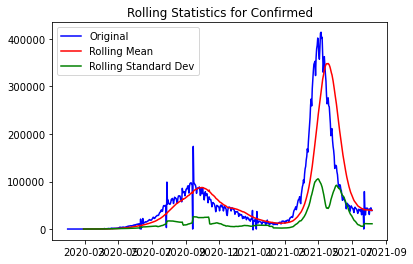

In [12]:
roll_stats(confirmed_ts, 30)

Date
2020-01-30              NaN
2020-01-31              NaN
2020-02-01              NaN
2020-02-02              NaN
2020-02-03              NaN
                  ...      
2021-08-03    118796.911111
2021-08-04    114672.400000
2021-08-05    110712.011111
2021-08-06    106658.933333
2021-08-07    103020.888889
Name: Confirmed, Length: 556, dtype: float64 Date
2020-01-30              NaN
2020-01-31              NaN
2020-02-01              NaN
2020-02-02              NaN
2020-02-03              NaN
                  ...      
2021-08-03    110552.543367
2021-08-04    106248.962098
2021-08-05    102011.855513
2021-08-06     97394.120590
2021-08-07     93621.430464
Name: Confirmed, Length: 556, dtype: float64


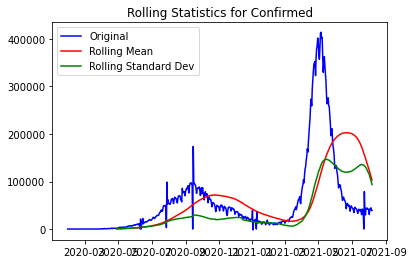

In [13]:
roll_stats(confirmed_ts, 90)

In [14]:
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(ts):
  '''Function to run Augmented Dicky Fuller test on the passed time series and report the statistics from the test'''
  print("Observations of Dickey-fuller test")
  dftest = adfuller(ts,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)

In [15]:
run_dicky_fuller(confirmed_ts)

Observations of Dickey-fuller test
Test Statistic                  -3.588594
p-value                          0.005983
#lags used                      13.000000
number of observations used    542.000000
critical value (1%)             -3.442473
critical value (5%)             -2.866887
critical value (10%)            -2.569618
dtype: float64


The original time-series is **Non-stationary**

<ipython-input-16-4005e9b62835>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(confirmed_ts, model='additive', freq=10)


<Figure size 432x288 with 0 Axes>

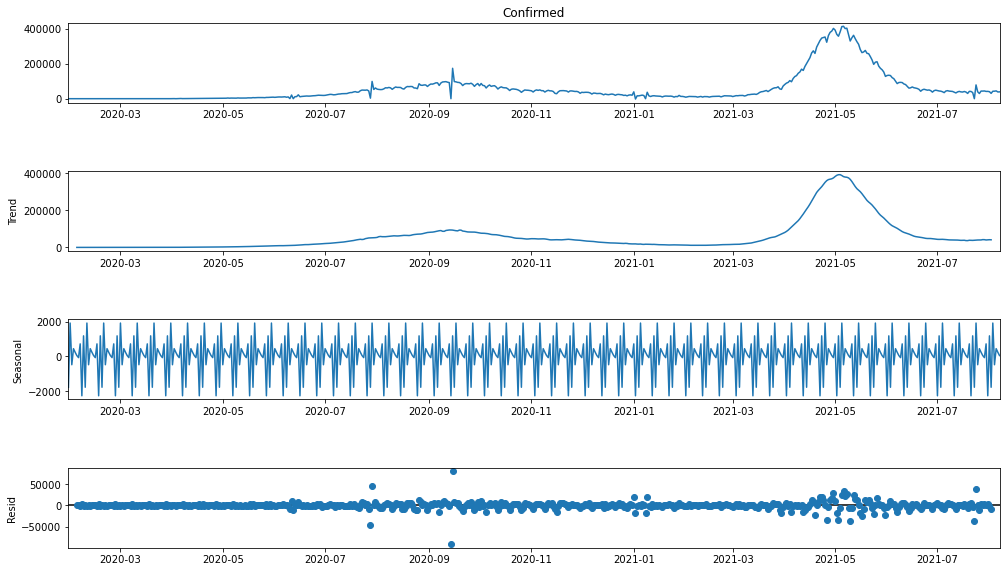

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(confirmed_ts, model='additive', freq=10)
fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(16, 9)

Date
2020-01-30           NaN
2020-01-31           NaN
2020-02-01           NaN
2020-02-02           NaN
2020-02-03           NaN
                 ...    
2021-08-03     94.300000
2021-08-04    275.966667
2021-08-05     30.333333
2021-08-06   -242.133333
2021-08-07   -144.100000
Name: Confirmed, Length: 556, dtype: float64 Date
2020-01-30             NaN
2020-01-31             NaN
2020-02-01             NaN
2020-02-02             NaN
2020-02-03             NaN
                  ...     
2021-08-03    18598.731655
2021-08-04    18572.915582
2021-08-05    18501.740597
2021-08-06    18529.478322
2021-08-07    18524.905616
Name: Confirmed, Length: 556, dtype: float64


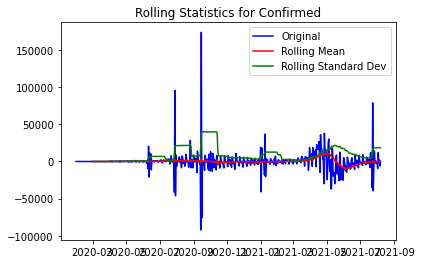

In [17]:
diff = confirmed_ts.diff() 
roll_stats(diff, 30)

Date
2020-01-30            NaN
2020-01-31            NaN
2020-02-01            NaN
2020-02-02            NaN
2020-02-03            NaN
                 ...     
2021-08-03   -4108.955556
2021-08-04   -4124.511111
2021-08-05   -3960.388889
2021-08-06   -4053.077778
2021-08-07   -3638.044444
Name: Confirmed, Length: 556, dtype: float64 Date
2020-01-30             NaN
2020-01-31             NaN
2020-02-01             NaN
2020-02-02             NaN
2020-02-03             NaN
                  ...     
2021-08-03    14576.960936
2021-08-04    14571.376771
2021-08-05    14552.205805
2021-08-06    14538.269028
2021-08-07    14116.773287
Name: Confirmed, Length: 556, dtype: float64


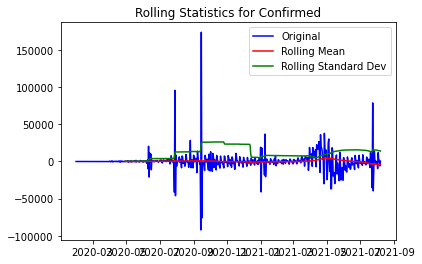

In [18]:
diff = confirmed_ts.diff() 
roll_stats(diff, 90)

In [19]:
run_dicky_fuller(diff.dropna())

Observations of Dickey-fuller test
Test Statistic                  -4.486888
p-value                          0.000208
#lags used                      19.000000
number of observations used    535.000000
critical value (1%)             -3.442632
critical value (5%)             -2.866957
critical value (10%)            -2.569655
dtype: float64


We see that after differencing the time-series looks stationary both in the rolling statistics plot as well as the Dicky-Fuller test

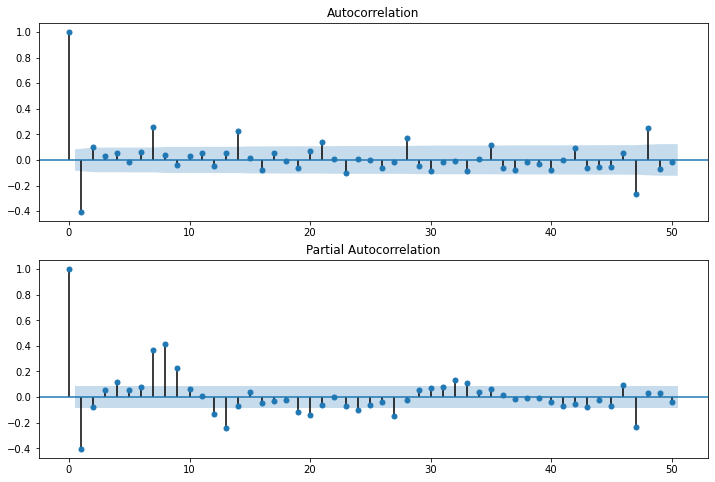

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff.dropna(), lags=50, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff.dropna(), lags=50, ax = ax2)

(p,q) = (1,1), (1,2), (2,1), (2,2) seem viable.

## ARIMA

In [21]:
from statsmodels.tsa.arima_model import ARIMA 

# ARIMA (3,1,2) and (1,1,2) show similar results but (3,1,2) chosen due to lower AIC value

# ARIMA(p,d,q) = (3,1,2)
model_ARIMA = ARIMA(confirmed_ts, order=(3,1,2))
results_ARIMA = model_ARIMA.fit()
results_ARIMA.summary()

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  555
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5945.480
Method:                       css-mle   S.D. of innovations          10839.786
Date:                Mon, 13 Dec 2021   AIC                          11904.960
Time:                        17:51:30   BIC                          11935.192
Sample:                    01-31-2020   HQIC                         11916.769
                         - 08-07-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                70.3946   1041.369      0.068      0.946   -1970.651    2111.440
ar.L1.D.Confirmed     1.1672      0.052     22.454      0.000       1.065       1.269
ar.L2.D.Confirmed    -0.0609      0.065     -0.935      0.350      -0.189       0.067
ar.L3.D.Confirmed    -0.1377      0.051     -2.715      0.007      -0.237      -0.038
ma.L1.D.Confirmed    -1.8430      0.028    -65.735      0.000      -1.898      -1.788
ma.L2.D.Confirmed     0.9168      0.024     37.965      0.000       0.870       0.964
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0519           +0.0000j            1.0519            0.0000
AR.2            1.9845           +0.0000j            1.9845            0.0000
AR.3           -3.4788           +0.0000j            3.4788            0.5000
MA.1            1.0051           -0.2837j            1.0444           -0.0438
MA.2            1.0051           +0.2837j            1.0444            0.0438
-----------------------------------------------------------------------------
"""

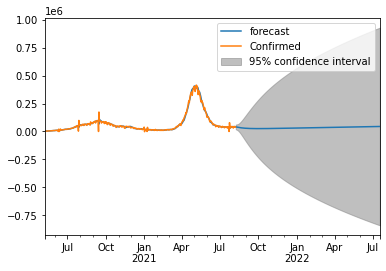

In [22]:
results_ARIMA.plot_predict(start = 100, end = 900, dynamic = False);

In [23]:
# ARIMA(p,d,q) = (1,1,0) - AR model
model_AR = ARIMA(confirmed_ts, order=(1,1,0))
results_AR = model_AR.fit()
results_AR.summary()

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  555
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6018.283
Method:                       css-mle   S.D. of innovations          12390.132
Date:                Mon, 13 Dec 2021   AIC                          12042.567
Time:                        17:51:31   BIC                          12055.524
Sample:                    01-31-2020   HQIC                         12047.628
                         - 08-07-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                70.3946    375.071      0.188      0.851    -664.730     805.519
ar.L1.D.Confirmed    -0.4029      0.039    -10.389      0.000      -0.479      -0.327
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.4817           +0.0000j            2.4817            0.5000
-----------------------------------------------------------------------------
"""

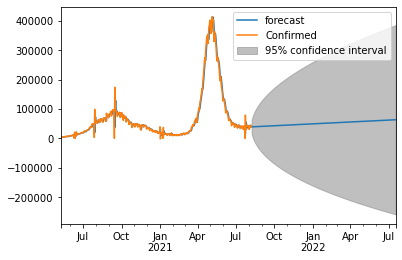

In [24]:
results_AR.plot_predict(start = 100, end = 900, dynamic = False);

In [25]:
# ARIMA(p,d,q) = (0,1,1) - MA model
model_MA = ARIMA(confirmed_ts, order=(0,1,1))
results_MA = model_MA.fit()
results_MA.summary()

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                  555
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6022.683
Method:                       css-mle   S.D. of innovations          12489.198
Date:                Mon, 13 Dec 2021   AIC                          12051.367
Time:                        17:51:31   BIC                          12064.324
Sample:                    01-31-2020   HQIC                         12056.428
                         - 08-07-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                70.3946    340.482      0.207      0.836    -596.938     737.727
ma.L1.D.Confirmed    -0.3584      0.032    -11.133      0.000      -0.421      -0.295
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            2.7902           +0.0000j            2.7902            0.0000
-----------------------------------------------------------------------------
"""

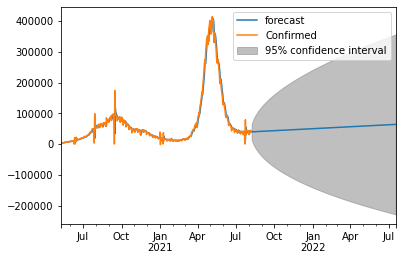

In [26]:
results_MA.plot_predict(start = 100, end = 900, dynamic = False);

Comparing AIC values of ARIMA, AR and MA we can see that ARIMA is the best, so we proceed with ARIMA

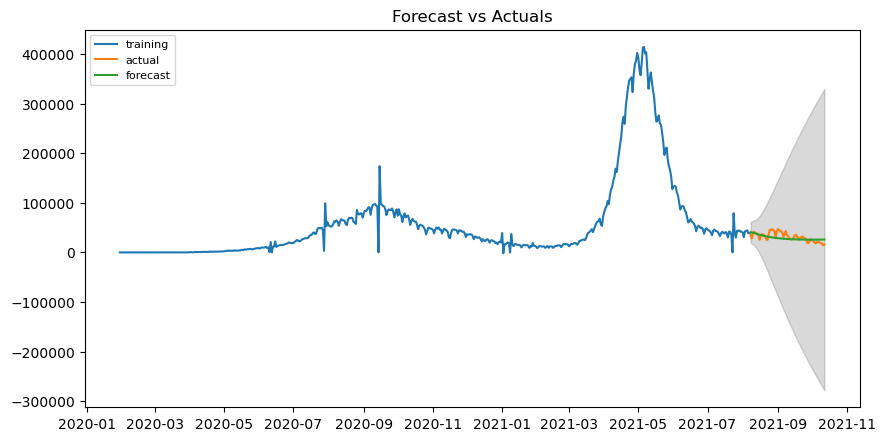

In [27]:
fc, se, conf = results_ARIMA.forecast(len(val), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
# plt.plot(lower_series, linestyle = '--', color = 'grey', label = '95% Confidence Interval')
# plt.plot(upper_series, linestyle = '--', color = 'grey')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# plt.savefig('../../figures/india_arima.eps', format='eps')

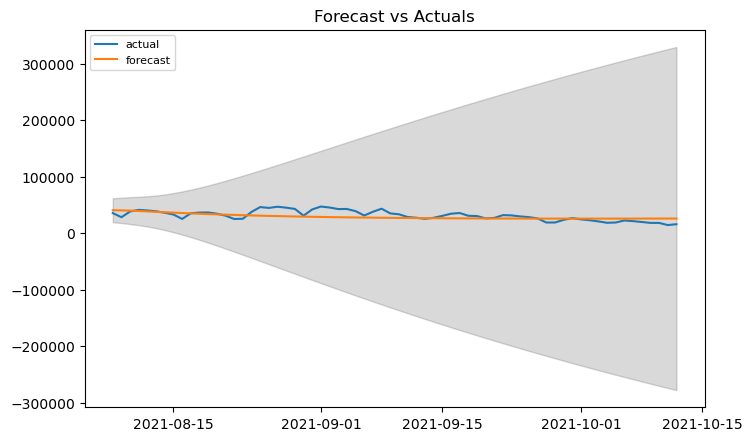

In [28]:
# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto-ARIMA

In [29]:
#!pip install pmdarima

In [30]:
import pmdarima 

In [31]:
model_autoARIMA = pmdarima.auto_arima(confirmed_ts)
model_autoARIMA.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

We see that auto-ARIMA picked out (p,d,q) = (3,1,2) for this particular train-val split, but for others it was noticed that (1,1,2) was picked. As the ACF and PACF also suggest (1,1,2) we go with that.

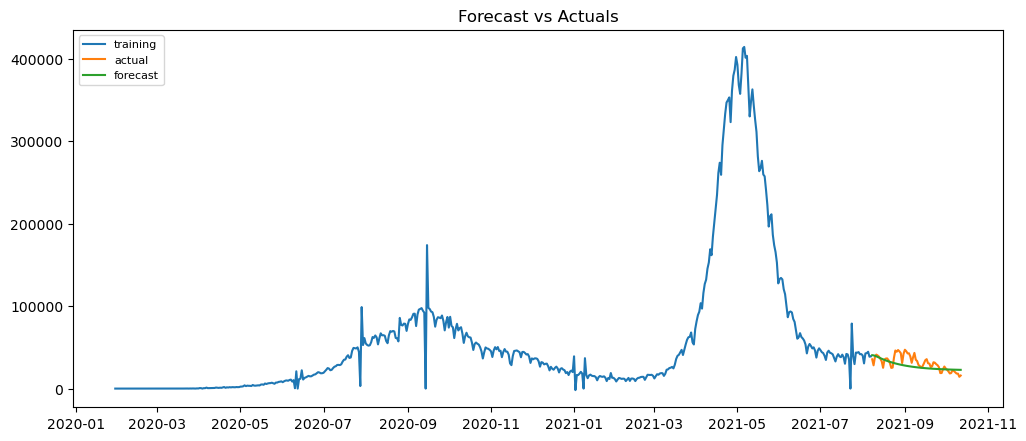

In [32]:
fc = model_autoARIMA.predict(n_periods=len(val))

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

For ARIMA we see that ARIMA(3,1,2) or ARIMA(1,1,2) is the most optimal, but still both of them are not accurate in predicting spikes

## SARIMAX

We now try SARIMAX, with p,d,q = (1,1,2). But getting the seasonal order (P,D,Q,S) is not obvious from ACF and PACF. So we will apply GridSearch to find the most optimal SARIMAX(p,d,q)(P,D,Q,S) model

In [33]:
model_autoSARIMA = pmdarima.auto_arima(confirmed_ts, seasonal=True)
model_autoSARIMA.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

Even with seasonal ARIMA considered, we see that seasonal models aren't as effective, as `auto_arima` has predicted seasonal_order of (0,0,0,0). The models are tested based on AIC internally and SARIMA with seasonal components seem to have performed worse than non-seasonal ARIMA

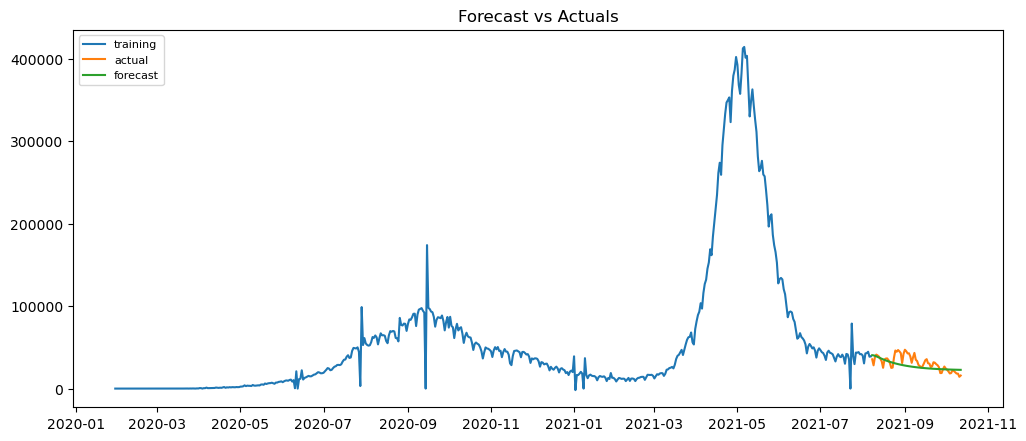

In [34]:
fc = model_autoSARIMA.predict(n_periods=len(val))

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
# lower_series = pd.Series(conf[:, 0], index=val.index)
# upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
## DO NOT RUN THIS CELL

# import statsmodels.api as sm
# import itertools
# # from sm.tsa.statespace import SARIMAX

# def sarimax(ts,pdq,seasonal_pdq):
#     results = []
#     for order in pdq:
#         for seas in seasonal_pdq:
#             print(order, seas)
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(ts,
#                               order=order,
#                               seasonal_order=seas)
#                 res = mod.fit()
#                 results.append((res,res.aic,param))
#                 print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
#             except Exception as e:
#                 print(e)
            
#     return results
# # set parameter range
# # p,d,q = range(0,3),[1],range(0,3)
# P,D,Q,s = range(0,2),[0],range(0,2),[250]
# # list of all parameter combos
# pdq = [(1,1,2)]
# seasonal_pdq = list(itertools.product(P, D, Q, s))
# # all_param = list(itertools.product(pdq,seasonal_pdq))
# # all_param = [(pdq, s) for s in seasonal_pdq]
# # for param in all_param:
# #     print(param)

# all_res = sarimax(confirmed_ts,pdq, seasonal_pdq)

# ARIMA + GARCH

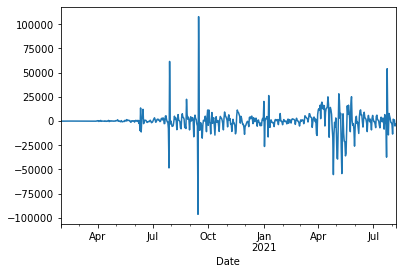

In [36]:
# Get the residuals from the ARIMA(1,1,2) model fit earlier 
resid = results_ARIMA.resid 
resid.plot()

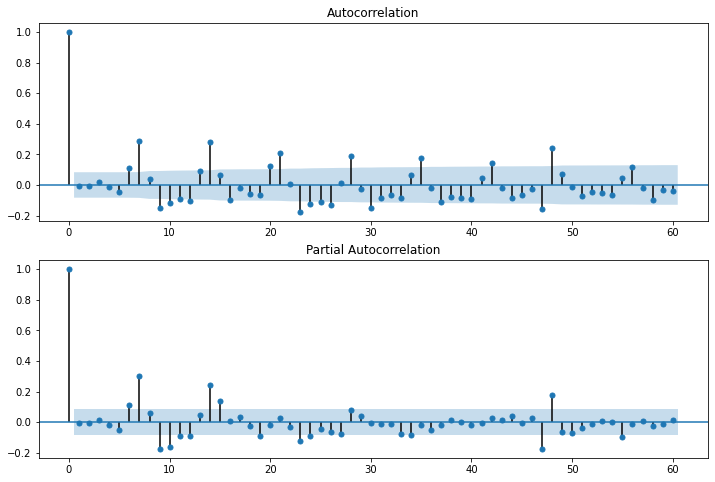

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid.dropna(), lags=60, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid.dropna(), lags=60, ax = ax2)

In [38]:
from arch import arch_model

resid_GARCH = arch_model(resid, p=1, q=1)
garch_fit = resid_GARCH.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6018.663831966825
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5725.062509909361
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5725.050845888349
Iteration:      4,   Func. Count:     22,   Neg. LLF: 5725.038382047929
Iteration:      5,   Func. Count:     27,   Neg. LLF: 5725.038194981735
Iteration:      6,   Func. Count:     32,   Neg. LLF: 5725.037199236465
Iteration:      7,   Func. Count:     37,   Neg. LLF: 5725.032176281036
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5725.007019205099
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5724.8838205419015
Iteration:     10,   Func. Count:     52,   Neg. LLF: 5724.315159000938
Iteration:     11,   Func. Count:     57,   Neg. LLF: 5722.539641496192
Iteration:     12,   Func. Count:     62,   Neg. LLF: 5722.094339855195
Iteration:     13,   Func. Count:     67,   Neg. LLF: 5722.089469938372
Iteration:     14,   Func. Count:     72,   Neg. LLF: 5722.0893

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.175e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [39]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5722.09
Distribution:                  Normal   AIC:                           11452.2
Method:            Maximum Likelihood   BIC:                           11469.5
                                        No. Observations:                  555
Date:                Mon, Dec 13 2021   Df Residuals:                      554
Time:                        17:52:01   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           403.6205    223.233      1.808  7.060e-02 [-33.909,8.411e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.3500e+06  1.016e+06      2.313  2.070e-02 [3.590e+05,4.341e+06]
alpha[1]       0.2868  9.750e-02      2.942  3.265e-03   [9.572e-02,  0.478]
beta[1]        0.7132      0.138      5.150  2.598e-07     [  0.442,  0.985]
============================================================================

Covariance estimator: robust
"""

In [40]:
resid_forecasts = garch_fit.forecast(horizon=len(val))
resid_fc = resid_forecasts.residual_variance.values[-1, :]
resid_fc
resid_fc = np.sqrt(resid_fc)

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


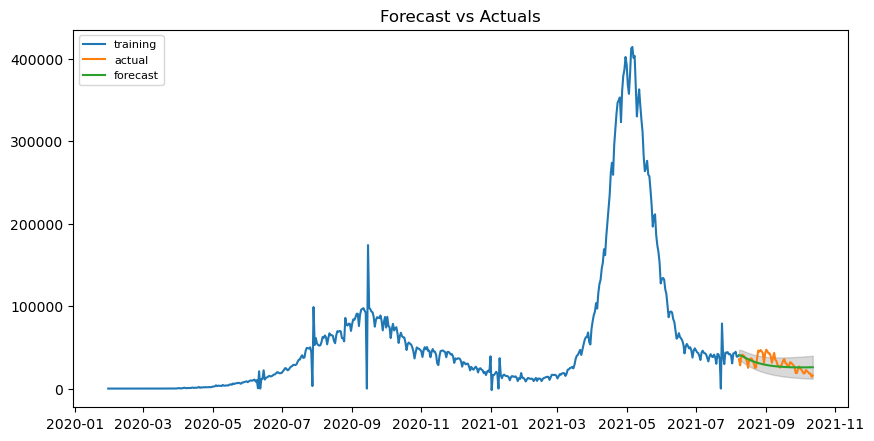

In [41]:
fc, se, conf = results_ARIMA.forecast(len(val), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, fc_series + resid_fc, fc_series - resid_fc, 
                 color='k', alpha=.15)
# plt.plot(fc_series + resid_fc, linestyle = '--', color = 'grey', label = '95% Confidence Interval')
# plt.plot(fc_series - resid_fc, linestyle = '--', color = 'grey')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# plt.savefig('../../figures/india_arima+garch.eps', format='eps')

We see that the Confidence Interval is now narrowed down and isn't exploding like earlier. GARCH has made the variance predictable hence the narrower CI. Without GARCH the CI was exponentially expanding (as can be seen earlier) which would lead to inaccurate prediction of variance

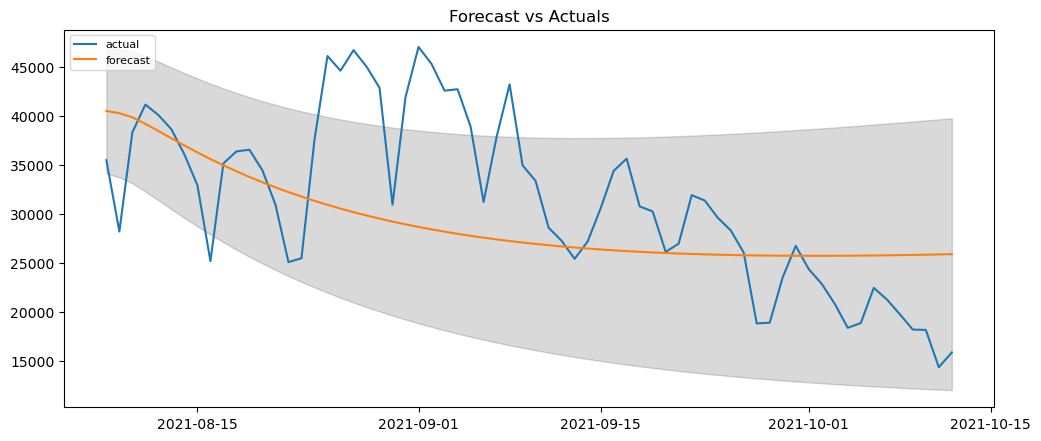

In [42]:
# Make as pandas series
fc_series = pd.Series(fc, index=val.index)
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, fc_series + resid_fc, fc_series - resid_fc, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Rolling forecasts (Short-term)

Here only the next days cases is predicted and the data is given to the ARIMA model as it comes in to predict the following days cases

In [43]:
history = confirmed_ts.copy()
print(history)

Date
2020-01-30        1.0
2020-01-31        0.0
2020-02-01        0.0
2020-02-02        1.0
2020-02-03        1.0
               ...   
2021-08-03    42625.0
2021-08-04    42982.0
2021-08-05    44643.0
2021-08-06    38628.0
2021-08-07    39070.0
Name: Confirmed, Length: 556, dtype: float64


In [44]:
roll_fc = pd.Series(index = val.index)
roll_resid = pd.Series(index = val.index)

<ipython-input-44-251050dfcea8>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  roll_fc = pd.Series(index = val.index)
<ipython-input-44-251050dfcea8>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  roll_resid = pd.Series(index = val.index)


In [45]:
#Only rolling ARIMA

for exp in val['Confirmed']:
    model = ARIMA(history, order=(3,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    roll_fc[newindex] = yhat[0]
    history[newindex] = exp

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/vish/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/t

In [46]:
#Rolling ARIMA + rolling GARCH

# for exp in val['Confirmed']:
#     model = ARIMA(history, order=(1,1,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     resid = model_fit.resid
#     roll_garch = arch_model(resid, p=1, q=1)
#     roll_garch_fit = roll_garch.fit(disp=-1)
#     garch_fc = roll_garch_fit.forecast().residual_variance.values[-1, :]
#     yhat = output[0]
#     newindex = history.index[-1] + pd.to_timedelta(1, 'D')
#     roll_fc[newindex] = yhat[0]
#     history[newindex] = exp
#     roll_resid[newindex] = np.sqrt(garch_fc)[0]

Date
2021-08-08    35499.0
2021-08-09    28204.0
2021-08-10    38353.0
2021-08-11    41195.0
2021-08-12    40120.0
               ...   
2021-10-08    19740.0
2021-10-09    18166.0
2021-10-10    18132.0
2021-10-11    14313.0
2021-10-12    15823.0
Name: Confirmed, Length: 66, dtype: float64


Date
2021-08-08    40541.103602
2021-08-09    38660.935483
2021-08-10    34469.363609
2021-08-11    34453.243838
2021-08-12    36031.477464
                  ...     
2021-10-08    16984.138512
2021-10-09    16667.791921
2021-10-10    16337.501019
2021-10-11    16489.939110
2021-10-12    15579.772440
Length: 66, dtype: float64

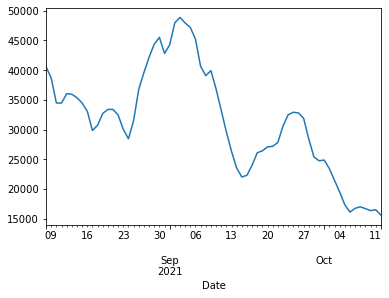

In [47]:
roll_fc.plot()
print(val['Confirmed'])
roll_fc

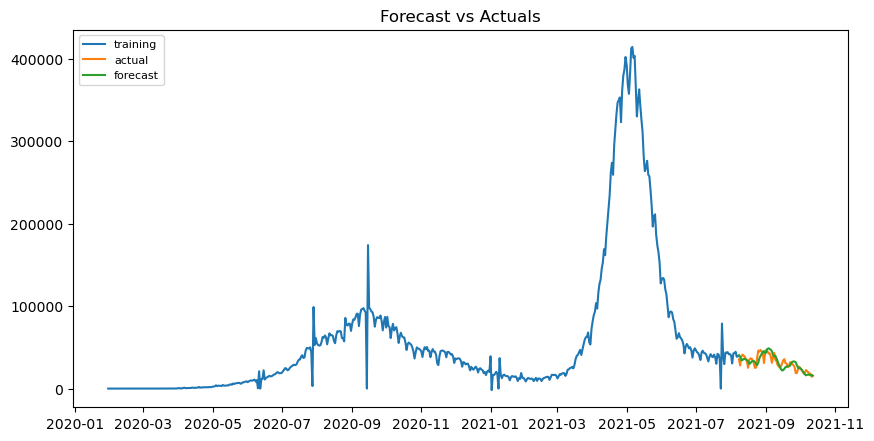

In [49]:
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(confirmed_ts, label='training')
plt.plot(val['Confirmed'], label='actual')
plt.plot(roll_fc, label='forecast')
# plt.fill_between(lower_series.index, roll_fc + resid_fc, roll_fc - resid_fc, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# plt.savefig('../../figures/india_arima_rolling.eps', format='eps')

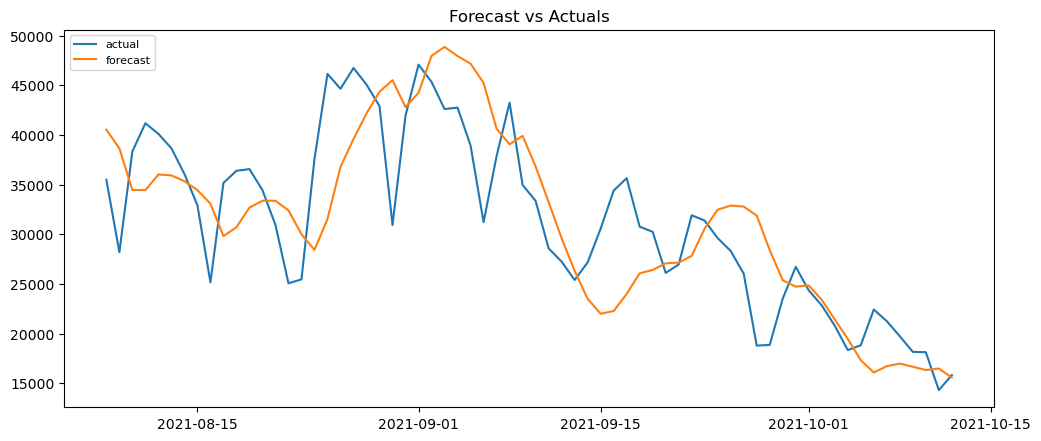

In [50]:
lower_series = pd.Series(conf[:, 0], index=val.index)
upper_series = pd.Series(conf[:, 1], index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val['Confirmed'], label='actual')
plt.plot(roll_fc, label='forecast')
# plt.fill_between(lower_series.index, roll_fc + resid_fc, roll_fc - resid_fc, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
# lower_series = pd.Series(conf[:, 0], index=val.index)
# upper_series = pd.Series(conf[:, 1], index=val.index)

# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(val['Confirmed'], label='actual')
# plt.plot(roll_fc, label='forecast')
# plt.fill_between(lower_series.index, roll_fc + roll_resid, roll_fc - roll_resid, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

## Evaluation Metrics

MAPE and MAE used

Comparing both short-term and long-term forecasts

In [57]:
def MAPE(Y_actual,Y_Predicted, title):
    mask = Y_actual != 0
    
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual)[mask])*100
#     print(mape)
    print(f"MAPE of {title} is {mape}%")
#     return mape[mape.index[0]]


mape_fc = MAPE(val['Confirmed'], fc_series, title="Long-term")
mape_roll = MAPE(val['Confirmed'], roll_fc, title="Short-term (rolling)")
# mape_cases = MAPE(test_original[['undiff_Confirmed']], fore_original[['undiff_Confirmed']], title="Daily cases")

MAPE of Long-term is 20.998117264837333%
MAPE of Short-term (rolling) is 15.457112082802654%


In [53]:
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError

mape_keras = MeanAbsolutePercentageError() 

print(mape_keras(val['Confirmed'], fc_series).numpy())
print(mape_keras(val['Confirmed'], roll_fc).numpy())

20.998117446899414
15.457112312316895


In [58]:
from sklearn.metrics import mean_absolute_error
print('MAE of Long-term:', mean_absolute_error(val['Confirmed'], fc_series))
print('MAE of short-term:', mean_absolute_error(val['Confirmed'], roll_fc))

MAE of Long-term: 6374.434803944042
MAE of short-term: 4688.902179542696
